# Datenworkshop CdV, DBSM, DEA, DDB

## 1. Grundlagen

- Karte abtippen
- Zettel als String
- Zettel als mehrere Strings
- Konkatenieren, Interpolieren

- Zettel als Dictionary

- Zettelkasten als List of Dictionaries

- Slicing, Indexing

## 2. Import
### Webseiten/HTTP-Inhalte downloaden mit requests


In [1]:
import requests

In [2]:
base_url = 'https://www.dnb.de/DE/Home/Newsblog/newsblog_artikel.html'
params = {'nn': '56936'}

In [3]:
response = requests.get(base_url, params=params)

In [1]:
from bs4 import BeautifulSoup as soup

In [5]:
daten_html = soup(response.content, 'html')

### SRU-Schnittstelle

https://www.dnb.de/DE/Professionell/Metadatendienste/Datenbezug/SRU/sru_node.html
https://services.dnb.de/sru/dnb?operation=explain&version=1.1

In [6]:
base_url = 'https://services.dnb.de/sru/dnb.dea.archivalien'

params = {'recordSchema': 'MARC21-xml',
          'operation': 'searchRetrieve',
          'version': '1.1',
          'accessToken': '8090beb04b8a8ce79c2da2c1ee6890b8',
          'maximumRecords': '100',
          'query': 'sigRef="EB 96/182-B*"'
         }

In [7]:
response = requests.get(base_url, params=params)

In [8]:
daten_xml = soup(response.content, 'xml')

In [9]:
with open('daten.xml', mode='w') as f:
    f.write(daten_xml.prettify())

## 2. Datenaufbereitung

In [2]:
with open('daten.xml', mode='r') as f:
    daten = f.read()

In [3]:
daten_xml = soup(daten, 'lxml')

In [4]:
records = daten_xml.find_all('record', {'type': 'Bibliographic'})

In [5]:
liste = []
for record in records:
    #idn
    try:
        idn = record.find('datafield', {'tag': '016'}).find('subfield', {'code': 'a'}).string.strip()
    except:
        idn = None
    
    #author
    try:
        author = record.find('datafield', {'tag': '100'}).find('subfield', {'code': 'a'}).string.strip()
    except:
        author = None
    
    #recipient
    try:
        recipient = record.find('datafield', {'tag': '700'}).find('subfield', {'code': 'a'}).string.strip() if record.find('datafield', {'tag': '700'}).find('subfield', {'code': '4'}).string.strip() == 'rcp' else None
    except:
        recipient = None
    
    #year
    try: 
        year = record.find('datafield', {'tag': '264'}).find('subfield', {'code': 'c'}).string.strip()
    except:
        year = None
    
    #place
    try:
        place = record.find('datafield', {'tag': '264'}).find('subfield', {'code': 'a'}).string.strip()
    except:
        try:
            place = record.find('datafield', {'tag': '264'}).find('subfield', {'code': 'b'}).string.strip()
        except:
            place = None

    #print(idn, author, recipient, year, place)
    
    entry = {'idn': idn, 'author': author, 'recipient': recipient, 'year': year, 'place': place}
    liste.append(entry)
    
#liste

## 3. Pandas

In [6]:
import pandas as pd

In [7]:
collection = pd.DataFrame(liste)

In [8]:
collection

,idn,author,recipient,year,place
0,992987555,"Adler, Hermann","Heilbut, Iwan",1948-1948,Basel
1,992988071,"Schlösser, Manfred",None,1960-1960,Darmstadt
2,993001580,"Huder, Walther","Heilbut, Iwan",1966-1968,Berlin
3,993005012,"Albers, Heinz","Heilbut, Iwan",1966-1969,Hamburg
4,993005098,"Sinhuber, Bartel F.","Heilbut, Iwan",1969-1969,München
...,...,...,...,...,...
95,993801994,"Herda, Wolfgang","Heilbut, Iwan",1960-1960,Oldenburg
96,99419286X,"Brüdern, Gerd","Heilbut, Iwan",1956-1956,München
97,994251076,"Bruer, Ursula","Heilbut, Iwan",1955-1955,Berlin-Wilmersdorf
98,994252005,None,"Heilbut, Iwan",1964-1964,Berlin


## 4. Geolokalisierung

In [9]:
import geopy.geocoders as geo
from geopy.extra.rate_limiter import RateLimiter

In [10]:
geolocator = geo.GeoNames(username='awendler', user_agent='dea-places')
geo.options.default_timeout = 10
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [11]:
collection['location'] = collection['place'][:10].apply(geocode)

In [14]:
collection

,idn,author,recipient,year,place,location
0,992987555,"Adler, Hermann","Heilbut, Iwan",1948-1948,Basel,"(Basel, Basel-City, Switzerland, (47.55839, 7...."
1,992988071,"Schlösser, Manfred",None,1960-1960,Darmstadt,"(Darmstadt, Hesse, Germany, (49.87167, 8.65027))"
2,993001580,"Huder, Walther","Heilbut, Iwan",1966-1968,Berlin,"(Berlin, Berlin, Germany, (52.52437, 13.41053))"
3,993005012,"Albers, Heinz","Heilbut, Iwan",1966-1969,Hamburg,"(Hamburg, Hamburg, Germany, (53.55073, 9.99302))"
4,993005098,"Sinhuber, Bartel F.","Heilbut, Iwan",1969-1969,München,"(Munich, Bavaria, Germany, (48.13743, 11.57549))"
...,...,...,...,...,...,...
95,993801994,"Herda, Wolfgang","Heilbut, Iwan",1960-1960,Oldenburg,NaN
96,99419286X,"Brüdern, Gerd","Heilbut, Iwan",1956-1956,München,NaN
97,994251076,"Bruer, Ursula","Heilbut, Iwan",1955-1955,Berlin-Wilmersdorf,NaN
98,994252005,None,"Heilbut, Iwan",1964-1964,Berlin,NaN


In [15]:
def find_lat(loc):
    try:
        lat = loc.latitude
    except:
        lat = None
    return lat

#collection['lat'] = collection['location'].apply(lambda loc: loc.latitude if loc else None)
collection['lat'] = collection['location'].apply(find_lat)

In [17]:
def find_lon(loc):
    try:
        lon = loc.longitude
    except:
        lon = None
    return lon

#collection['lon'] = collection['location'].apply(lambda loc: loc.longitude if loc else None)
collection['lon'] = collection['location'].apply(find_lon)

In [18]:
collection

,idn,author,recipient,year,place,location,lat,lon
0,992987555,"Adler, Hermann","Heilbut, Iwan",1948-1948,Basel,"(Basel, Basel-City, Switzerland, (47.55839, 7....",47.55839,7.57327
1,992988071,"Schlösser, Manfred",None,1960-1960,Darmstadt,"(Darmstadt, Hesse, Germany, (49.87167, 8.65027))",49.87167,8.65027
2,993001580,"Huder, Walther","Heilbut, Iwan",1966-1968,Berlin,"(Berlin, Berlin, Germany, (52.52437, 13.41053))",52.52437,13.41053
3,993005012,"Albers, Heinz","Heilbut, Iwan",1966-1969,Hamburg,"(Hamburg, Hamburg, Germany, (53.55073, 9.99302))",53.55073,9.99302
4,993005098,"Sinhuber, Bartel F.","Heilbut, Iwan",1969-1969,München,"(Munich, Bavaria, Germany, (48.13743, 11.57549))",48.13743,11.57549
...,...,...,...,...,...,...,...,...
95,993801994,"Herda, Wolfgang","Heilbut, Iwan",1960-1960,Oldenburg,NaN,NaN,NaN
96,99419286X,"Brüdern, Gerd","Heilbut, Iwan",1956-1956,München,NaN,NaN,NaN
97,994251076,"Bruer, Ursula","Heilbut, Iwan",1955-1955,Berlin-Wilmersdorf,NaN,NaN,NaN
98,994252005,None,"Heilbut, Iwan",1964-1964,Berlin,NaN,NaN,NaN


In [25]:
collection.to_csv('collection.csv', index=None)

In [19]:
collection = pd.read_csv('collection_full.csv')

In [20]:
import plotly.express as px

In [28]:
collection[collection['author'] == 'Heilbut, Iwan']

,author,idn,place,recipient,year,location,lat,lon
29,"Heilbut, Iwan",993729711,"New York, NY","Bergengruen, Werner",1948-1948,"New York, New York, United States",40.71427,-74.00597
30,"Heilbut, Iwan",993750249,"New York, NY","Berger, David",1948-1948,"New York, New York, United States",40.71427,-74.00597
31,"Heilbut, Iwan",993750354,"New York, NY","Berghof, ...",1942-1942,"New York, New York, United States",40.71427,-74.00597
32,"Heilbut, Iwan",993751288,"New York, NY","Bergner, Elisabeth",1945-1945,"New York, New York, United States",40.71427,-74.00597
33,"Heilbut, Iwan",993753094,"New York, NY","Berlowitz, Klara",1942-1942,"New York, New York, United States",40.71427,-74.00597
...,...,...,...,...,...,...,...,...
1100,"Heilbut, Iwan",993484506,Tübingen,"Merkel, H.",1953-1953,"Tübingen, Baden-Württemberg, Germany",48.52266,9.05222
1274,"Heilbut, Iwan",999674536,Landshut,"Weber, Willibald",1953-1953,"Landshut, Bavaria, Germany",48.52961,12.16179
1316,"Heilbut, Iwan",996529055,Fulda,"Jennerich, Louise",1952-1952,"Fulda, Hesse, Germany",50.55162,9.67518
1317,"Heilbut, Iwan",996598022,"München, Nizza u.a.","Keller, Josef",1961-1971,NaN,NaN,NaN


In [32]:
fig = px.scatter_geo(collection[collection['recipient'] == 'Heilbut, Iwan'], lat='lat', lon='lon', scope='world', hover_data=['place', 'recipient'])

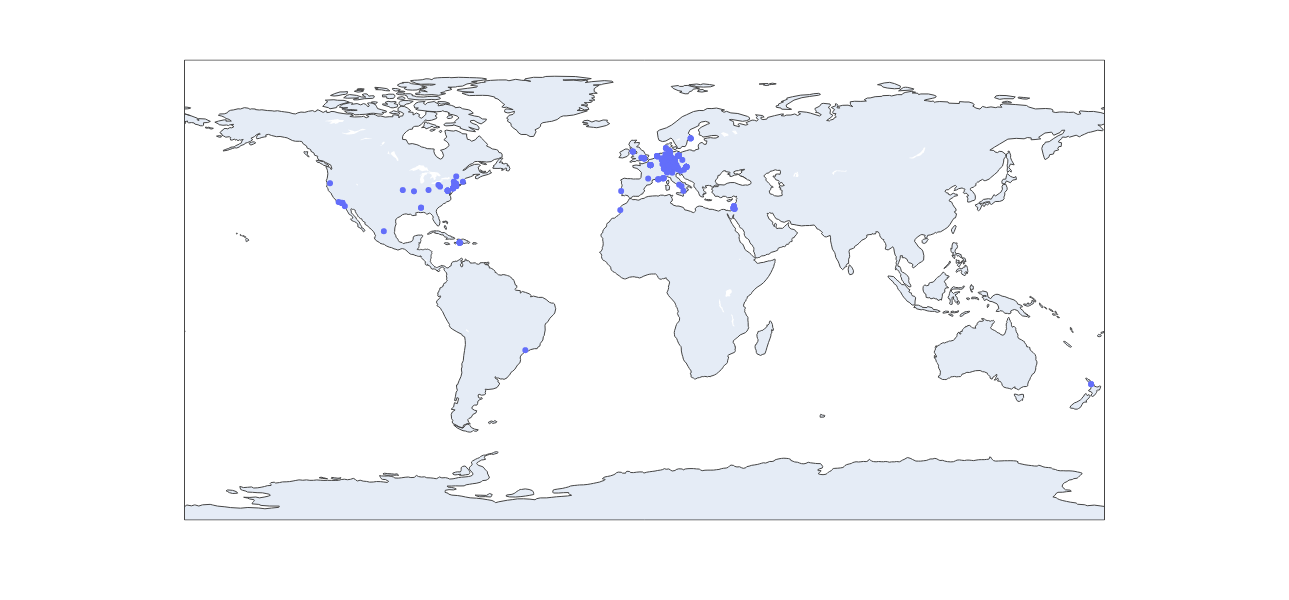

In [33]:
fig.show()